In [1]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from stability_diagrams import plot_stability_ssms
from stability_diagrams import plot_stability_lmm

# HW 5:  ODE Methods - Initial Value Problems

These questions will use a mixture of scipy routines and hand-rolled ODE solver methods (which you can use from the notes)

## Question 1 - The SIR model for Infectious diseases

ODE based models are a classical approach to understanding the spread of infectious diseases.

One of the pioneering models is the SIR model of [Kermack and McKendrick, (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118) which is a mean-field theory for large populations that assumes the general population can be divided into three subgroups

* $S$: the number of susceptible patients
* $I$: the number of infected patients
* $R$: the number of recovered (or otherwise) patients

Given these definitions, the simplest dynamical systems for the three populations can be written

$$
\begin{aligned}
\frac{d S}{dt} &= -\alpha SI \\
\frac{d I}{dt} &= \alpha SI -\beta I\\
\frac{d R}{dt} &= \beta I \\
\end{aligned}
$$

where $\alpha$ is the infection rate per person, and $\beta$ is the recovery rate (hint: check the units) 

This is the original Kermack and McKendrick model.  We will discuss a host of themes and variations later.  If you are interested [Siettos and Russo, (2013)](https://doi.org/10.4161/viru.24041) provides a short overview of the much larger field of epidemiology modeling (although this paper has some significant mistakes with respect to the analysis of the Kermack and McKendrick model, and I'm sure there are considerably more papers on modeling epidemics now).

We will explore this problem through a combination of Analysis and Numerical methods and to use it to test different methods for ODE solvers.


**(a)** [4] First try to explain in words,  what this system of ODE's describes

We assume everyone in the population is categorized in one of the groups: susceptible, infected, and recovered. The susceptibles can become infected, and the infected can become recovered. The rate of infection in susceptibles is proportional to the product of current number of susceptibles and infected patients. The rate of infected patients recovering is proportional to the number of infections. The rate of changes in number of infected patients is then the rate of infection minus the rate of recovering. 

### Some analysis.  

Here we will conduct some elementary dimensional analysis to reduce the parameter space.  More detailed analysis of this system can be found  in Steve Strogatz' excellent text on [dynamical systems](https://smile.amazon.com/Nonlinear-Dynamics-Chaos-Applications-Nonlinearity/dp/0813349109/ref=dp_ob_image_bk)

**(b)** [2] Show that the SIR equations imply that   $S + I + R = N$  where $N$ is a constant (the total population of susceptible people that can all interact)

We have 
\begin{align*}
\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt}  &= \frac{d(S + I + R)}{dt} \\ 
&= -\alpha SI + \alpha SI - \beta I + \beta I \\
&= 0. 
\end{align*}
By integrating both sides respect to $t$, we get 
\begin{align*}
\frac{d(S + I + R)}{dt} dt
&= S + I + R \\
&= N, 
\end{align*}
which is a constant. 

**(c)**  [4] Show that under  the change of variables (linear scaling of the variables)

$$
\begin{matrix}
    S = N s, & I = Ni, & R = Nr, & t = \tau\frac{1}{\alpha N} \\
\end{matrix}
$$

The original equations can be rewritten as the scaled equations 

$$
\begin{align}
    \frac{d s}{d\tau} &= -si\\
    \frac{d i}{d\tau} &= (s - s^*)i  \\
    \frac{d r}{d\tau} & = s^* i \\
\end{align}
$$

where 
$$
    s^* = \frac{\beta}{\alpha N}
$$



**Notes**,  
* if we write $s = S/N$ etc. then $s$ is simply the fraction of the total population that is susceptible.  
* Also show that $s + i + r = 1$.
* this scaling reduces a two-parameter problem to a one parameter problem where the only variable is $s^*$



Using the chain rule, 
\begin{align*}
    \frac{ds}{d\tau} &= \frac{ds}{dS} \cdot \frac{dS}{dt} \cdot \frac{dt}{d\tau} \\ 
    &= \frac{1}{N} \cdot (-\alpha N s \cdot N i) \cdot \frac{1}{\alpha N} \\ 
    &= -si. 
\end{align*}
Similarly, let $s^{*}i = \frac{\beta}{\alpha N}$, we have 
\begin{align*}
    \frac{di}{d\tau} &= \frac{di}{dI} \cdot \frac{dI}{dt} \cdot \frac{dt}{d\tau} \\ 
    &= \frac{1}{N} \cdot (\alpha N s \cdot N i - \beta N i) \cdot \frac{1}{\alpha N} \\ 
    &= si - \frac{\beta}{\alpha N} i \\
    &= (s - s^{*})i. 
\end{align*}

\begin{align*}
    \frac{dr}{d\tau} &= \frac{dr}{dR} \cdot \frac{dR}{dt} \cdot \frac{dt}{d\tau} \\ 
    &= \frac{1}{N} \cdot (\beta N i) \cdot \frac{1}{\alpha N} \\ 
    &= \frac{\beta}{\alpha N} i \\
    &= s^{*}i. 
\end{align*}

**(d)**  [2] Given that $s^*$ is a constant that only depends on the infection rate per capita $\alpha$, the recovery rate $\beta$ and the total population $N$,  interpret the equation for the change in the number of infections

$$
    \frac{d i}{d\tau} = (s - s^*) i
$$
as a function of the susceptible fraction of the population $s$.

We can see that when the population of susceptibles is large, such that $s > s^{*}$, the change in the number of infections is positive, meaning a increase in the number of infections. When the number of susceptibles is low, such that $s < s^{*}$, the number of infected patients decreases. When $s = s^{*}$, the number of infections keeps the same. 

### Numerical Methods

we will now explore the behavior of this model numerically using a range of our basic algorithms by solving the scaled dynamical system

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{F}(t,\mathbf{u}, s^*),\quad\mathbf{u}(0)=\mathbf{u}_0
$$

where 
$$
    \mathbf{u} = \begin{bmatrix} s \\ i \\ r \\ \end{bmatrix}, \quad 
    \mathbf{F}(t,\mathbf{u},s^*) = \begin{bmatrix} -si \\ (s - s^*)i \\ s^*i \\ \end{bmatrix}
$$

**(e)** [4] Write function to return the RHS of the scaled dynamical system $\mathbf{F}(t,\mathbf{u},s^*)$ as a numpy array

In [2]:
def F(t, u, s_star):
    """ RHS of scaled SIR model of Kermack and McKendrick
    
    parameters
    ----------
        t: float
            time (just a dummy variable here because this is an autonomous system)
        u: numpy array
            array of scaled [ s, i, r ] values such that sum(u) = 1 
            (and s,i, r are fractions of the total population N)
        s_star: float
            scaled critical susceptible population = \beta/(\alpha N)
            
    returns:
        F(u): numpy array
    """
    s, i, r = u
    return numpy.array([-s * i, (s - s_star) * i, s_star * i])

In [3]:
# Let's assume the critical level of immunity is 60% of the total population
s_star = 0.6

# let there initially be .01 % infected cases and no recovered
t = 0.
i_0 = 1.e-4
u_0 = numpy.array([1. - i_0, i_0, 0.0])
answer = numpy.array([-9.999000000000001e-05,  3.999000000000001e-05, 6.000000000000000e-05])
numpy.testing.assert_allclose(F(t, u_0, s_star), answer)
print('success!')

success!


**(f)** [10] Use scipy.integrate.solve_ivp (imported above as solve_ivp),  to solve the scaled dynamical system above with for <font color="red">$s^* = 0.6$</font> and initial condition

$$
    \mathbf{u}_0 = \begin{bmatrix} 1 - i_0\\ i_0 \\ 0\\ \end{bmatrix}
$$

where $i_0=10^{-5}$ is the initially infected proportion of the available population $N$

Integrate for $t\in[0, 50]$ and make a plot showing the evolution of $s(t)$, $i(t)$, ${r}(t)$ vs. time 

**For full credit your plot should show the following**
* show the actual time-steps chosen by the adaptive solver as well as a smooth solution (use dense_output=True) 
* the total cumulative number of cases at any time
* the time and infection level of the peak of the infection (hint: use the `events`, feature of solve_ivp)
* the maximum fraction of people infected

Explore the behavior of the solutions as a function of $s^*$ and $i_0$ and try to "flatten the curve" (we will try to make that more quantitative later). Also,  explore relative and absolute tolerances to convince yourself that your solutions are well resolved.

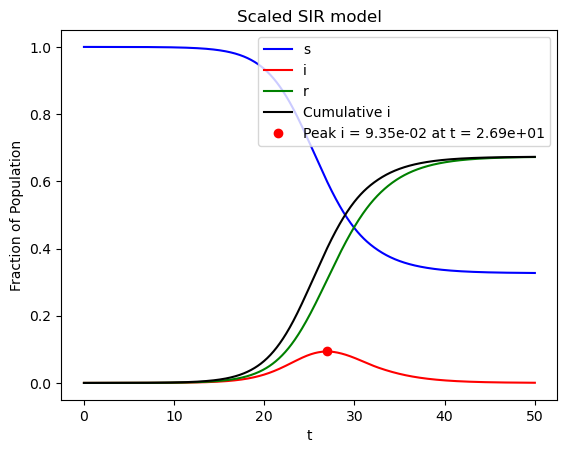

Actual time step =  0.12232249858172807
Maximum fraction of infected individuals =  0.09353597574923649


In [4]:
def peak_I(t, u, s_star):
    return u[0] - s_star

i0 = (10.)**(-5)
u0 = numpy.array([1. - i0, i0, 0.])

sol = solve_ivp(F, (0., 50.), u0, args=(s_star, ), dense_output=True, events=peak_I, rtol=1.e-3,atol=1.e-8)

t = numpy.linspace(0., 50., 1000)
z = sol.sol(t)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, z[0], label='s', color='blue')
axes.plot(t, z[1], label='i', color='red')
axes.plot(t, z[2], label='r', color='green')
axes.plot(t, z[1] + z[2], label='Cumulative i', color='black')
axes.plot(sol.t_events[0], sol.y_events[0][0][1], 'ro', label=f'Peak i = {sol.y_events[0][0][1]:.2e} at t = {sol.t_events[0][0]:.2e}')

axes.set_title('Scaled SIR model')
axes.set_xlabel('t')
axes.set_ylabel('Fraction of Population')
axes.legend()
plt.show()

print('Actual time step = ', sol.t[1] - sol.t[0])
print('Maximum fraction of infected individuals = ', sol.y_events[0][0][1])

**(g)** [8] Write your own code to solve the same system using any constant step-size method we discussed in class that is higher than 2nd order (you can use or modify any of the example codes from the notes and make sure it works for vector valued functions.   Your code should be able to use your function $F$ defined above. Make sure to choose a method that will work for the non-linear right-hand-side. We will test it against the output from solve_ivp with N steps uniform steps in $t\in[0,50]$.  What is the minimum number of steps does your routine take to pass the tests with a relative error of $10^{-4}$ and absolute error of $10^{-5}?.  You can control the number of steps taken with the `N=??` defined at the end of the cell.  **Extra Credit** determine the convergence rate of your method.

In [ ]:
def my_ode_solver(f, t_span, u0, N):
    """ implement constant step size ODE integrator using a RK4 method
    
    parameters
    ----------
        f: calleable
            vector valued function with interface f(t,u) where u is the state vector
        t_span: float list or array (or tuple)
            array holding range of times to integrate over t_span = [ t_min, t_max]
        u0:  numpy array
            array of initial conditions
        N: integer
            number of time steps to take 
            
    returns:
    --------
        t: numpy array
            array of timesteps from t_min to t_max of length N
        u: numpy array of shape (len(u0), len(t))
            solution array,  the solution at timestep i should be u[:,i]
    """
    
    t_min, t_max = t_span
    h = (t_max - t_min) / N  # Step size
    t = numpy.linspace(t_min, t_max, N+1)  # Time points
    u = numpy.zeros((len(u0), len(t)))  # Array to store the solution
    u[:, 0] = u0  # Set initial condition

    for i in range(N):
        # Current time and state
        ti = t[i]
        ui = u[:, i]

        # RK4 steps
        k1 = f(ti, ui)
        k2 = f(ti + h / 2, ui + h / 2 * k1)
        k3 = f(ti + h / 2, ui + h / 2 * k2)
        k4 = f(ti + h, ui + h * k3)

        # Update next state
        u[:, i + 1] = ui + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return t, u

N = 101

In [ ]:
s_star = 0.6
f = lambda t, u: F(t, u, s_star)

t_span = [0., 50.]
i_0 = 1.e-5
u_0 = numpy.array([1. - i_0, i_0, 0.0])


t, u = my_ode_solver(f, t_span, u_0, N)

# There was a hidden line here implementing sol = solve_ivp to get the "True" solution
sol = solve_ivp(f, t_span, u_0, method='RK45', dense_output=True, rtol=1.e-6, atol = 1.e-8)

numpy.testing.assert_allclose(u, sol.sol(t), rtol=1.e-4, atol=1.e-5)
print('success!')

success!


**(h)** [2] Reproduce your figure from the scipy version (without events)

###  Themes and Variations -- Some project ideas

The classical Kermack and McKendric model is only one of a vast set of models used to model the spread of infection disease but assumes homogeneous mixing across the entire population.  In addition there are lots of things  to explore with even the simplest SIR model.   If you are interested in this sort of ODE model as a possible project, here are a few things you might want to explore


* Choose a fixed value of $N$ for the maximum susceptible population. Assume that maximum hospital capacity is achieved when the number of infected patients reaches $i_{max}$.  Construct a root-finding problem to find the value of $s^*$ required to keep  the peak number of infected cases $i_{peak} <= i_{max}$. 

* Consider the possibility of re-infection (ugh!).  One model of this assumes that recovered patients can become susceptible again at some rate $\lambda$.  Modify the original SIR model to include this possibility and construct a new scaled set of equations.  This will now be a 2 parameter dynamical system ($s^*$ and another parameter say $\lambda^*$.  Explore the behavior of this new problem.

* Develop a model that includes the effects of vaccinations

* Show that the original SIR model allows at most one peak in infections.  Then try to construct a better model that allows multiple peaks.

* Read [Siettos and Russo, (2013)](https://doi.org/10.4161/viru.24041) (or find a better paper) which reviews a range of epidemiology models including Stochastic SIR models. Wikipedia also has several pages on modeling epidemics ([here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) , and [here](https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease)) Pick another model, implement it and compare it's behavior with the basic SIR model.

* Something Numerical: Write an adaptive time stepper built around any two single-step multi-stage schemes and compare your solution to solve_ivp.

* Your own best ideas!



## Question 2 - Absolute Stability Regions Single-Step Multi-stage schemes

**(a)** [4 pt] Taylor Series method:
    
Show that $R(z)$ for a Taylor's series method of order $p$ acting on the model problem $u'=\lambda u$ always just returns the first $p+1$ terms of the Taylor series of $e^z$.

A Taylor series method of order $p$ for $u' = \lambda u$ is given by 
\begin{align*}
    u(\Delta t) = u(0 + \Delta t) = u(0) = \Delta t \cdot u'(0) + \frac{(\Delta t)^2}{2!} u''(0) + \cdots + \frac{(\Delta t)^p}{p!} u^{(p)}(0) + O((\Delta t)^{p+1}). 
\end{align*}
Using $u' = \lambda u$ and $u(0) = U_0$, 
\begin{align*}
    U(\Delta t) &= U_0 + \lambda \Delta t \cdot U_0 + \frac{(\lambda t)^2}{2!} \cdot U_0 + \cdots + \frac{(\lambda \Delta t)^p}{p!} + O((\Delta t)^{p+1}) \\ 
    &= U_0 \cdot (1 + \lambda \Delta t + \frac{(\lambda \Delta t)^2}{2!} + \cdots + \frac{(\lambda \Delta t)^p}{p!}) + O((\Delta t)^{p+1}) \\ 
    &= R(z) U_0. 
\end{align*}
Thus, with $z = \lambda \Delta t$, 
\begin{align*}
    R(z) = 1 + z + \frac{z^2}{2!} + \cdots + \frac{z^p}{p!}, 
\end{align*}
which is the same as the first $p+1$ terms of Taylor series of $e^z$. 

**(b)** [4 pt] Plot the regions of absolute stability for Taylor Series methods of order 2-5

You can use the plotting codes given in class and included in the file stability_diagrams.py which are imported in the first cell

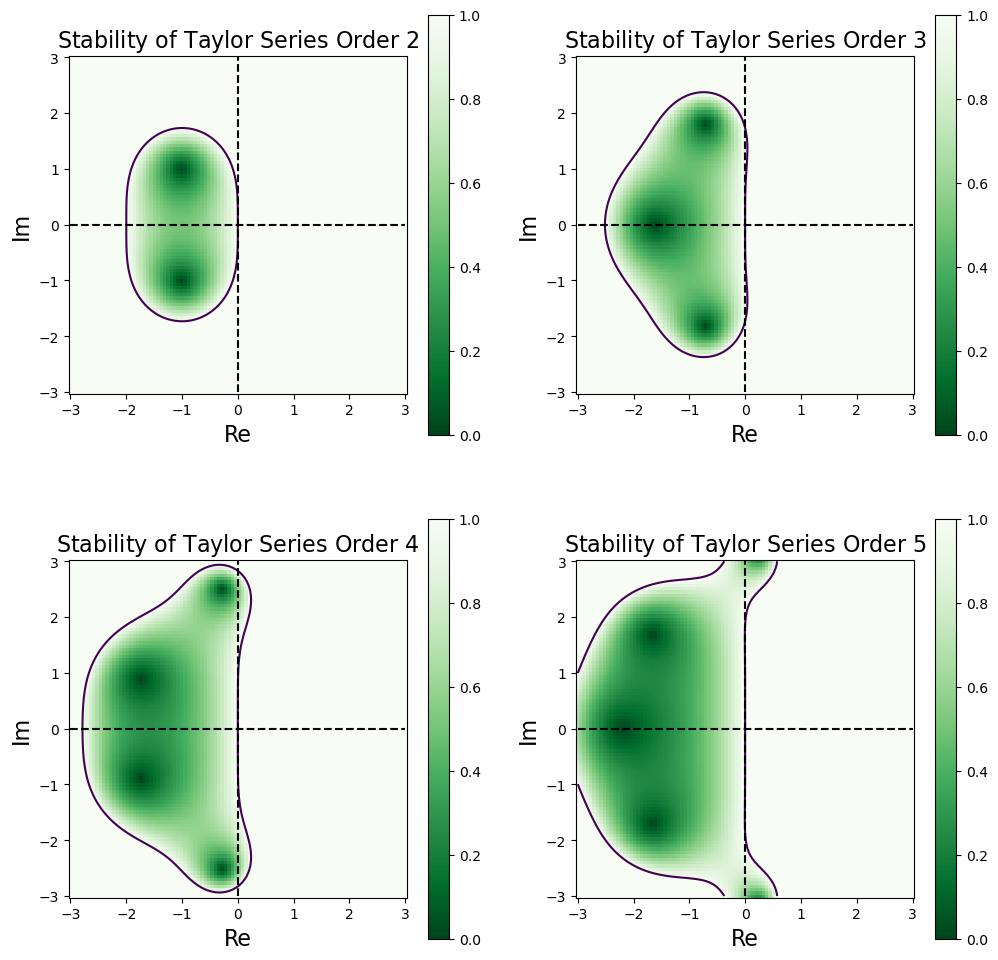

In [5]:
x = numpy.linspace(-3,3,100)
y = numpy.linspace(-3,3,100)

R_Taylor_2 = lambda z: 1 + z + z**2 / 2
R_Taylor_3 = lambda z: 1 + z + z**2 / 2 + z**3 / 6 
R_Taylor_4 = lambda z: 1 + z + z**2 / 2 + z**3 / 6 + z**4 / 24
R_Taylor_5 = lambda z: 1 + z + z**2 / 2 + z**3 / 6 + z**4 / 24 + z**5 / 120

continuous=True

fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2,2,1)
plot_stability_ssms(R_Taylor_2, x, y, axes=axes, title='Stability of Taylor Series Order $2$', continuous=continuous)

axes = fig.add_subplot(2,2,2)
plot_stability_ssms(R_Taylor_3, x, y, axes=axes, title='Stability of Taylor Series Order $3$', continuous=continuous)

axes = fig.add_subplot(2,2,3)
plot_stability_ssms(R_Taylor_4, x, y, axes=axes, title='Stability of Taylor Series Order $4$', continuous=continuous)

axes = fig.add_subplot(2,2,4)
plot_stability_ssms(R_Taylor_5, x, y, axes=axes, title='Stability of Taylor Series Order $5$', continuous=continuous)

**(b)** [4 pt] Derive $R(z)$ for the RK2 method and show that it is equivalent to Taylor 2

**Extra Credit**  show that $R(Z)$ for RK4 is identical to Taylor-4 (in general this is true for explicit RK methods)

Since for RK2 method, we have
\begin{align*}
    U_1 = U_0 + \Delta t f(U_0 + \frac{1}{2} \Delta t f(U_0)), 
\end{align*}
using $f(u) = \lambda u$, 
\begin{align*}
    U_1 &= U_0 + \Delta t (f(U_0 + \frac{1}{2} \lambda \Delta t U_0) \\ 
    &= U_0 + \Delta t (\lambda (U_0 + \frac{1}{2} \lambda \Delta t U_0)) \\ 
    &= U_0 + \lambda \Delta t U_0 + \frac{(\lambda \Delta t)^2}{2} U_0 \\ 
    &= U_0 (1 + \lambda \Delta t + \frac{(\lambda \Delta t)^2}{2}) \\ 
    &= R(z) U_0, 
\end{align*}
where 
\begin{align*}
    R(z) = 1 + z + \frac{z^2}{2}. 
\end{align*}
This is the first $3$ terms of Taylor series of $e^z$, proving that $R(z)$ for RK2 is equivalent to Taylor 2. 

For RK4 method, 
\begin{align*}
    K_1 = \Delta t f(t_0, U_0) = \lambda \Delta t U_0. 
\end{align*}
\begin{align*}
    K_2 &= \Delta t f(t_0 + \frac{\Delta t}{2}, U_0 + \frac{K_1}{2}) \\ 
    &= \lambda \Delta t (U_0 + \frac{\lambda \Delta t U_0}{2}) \\
    &= \lambda \Delta t U_0 + \frac{(\lambda \Delta t)^2}{2} U_0. 
\end{align*}
\begin{align*}
    K_3 &= \Delta t f(t_0 + \frac{\Delta t}{2}, U_0 + \frac{K_2}{2}) \\ 
    &= \lambda \Delta t (U_0 + \frac{\lambda \Delta t U_0 + \frac{(\lambda \Delta t)^2}{2} U_0}{2}) \\ 
    &= \lambda \Delta t U_0 + \frac{(\lambda \Delta t)^2}{2} U_0 + \frac{(\lambda \Delta t)^3}{4} U_0. 
\end{align*}
\begin{align*}
    K_4 &= \Delta t f(t_0 + \Delta t, U_0 + K_3) \\ 
    &= \lambda \Delta t (U_0 + \lambda \Delta t U_0 + \frac{(\lambda \Delta t)^2}{2} U_0 + \frac{(\lambda \Delta t)^3}{4} U_0) \\
    &= \lambda \Delta t U_0 + (\lambda \Delta t)^2 U_0 + \frac{(\lambda \Delta t)^3}{2} U_0 + \frac{(\lambda \Delta t)^4}{4} U_0. 
\end{align*}
Thus, 
\begin{align*}
    U_1 &= U_0 + \frac{1}{6}(K_1 + 2 (K_2 + K_3) + K_4) \\ 
    &= U_0 + \frac{1}{6}(K_1 + K_4 + 4 \lambda \Delta t U_0 + 2 (\lambda \Delta t)^2 U_0 + \frac{(\lambda \Delta t)^3}{2} U_0 ) \\ 
    &= U_0 + \frac{1}{6}(2 \lambda \Delta t U_0 + (\lambda \Delta t)^2 U_0 + \frac{(\lambda \Delta t)^3}{2} U_0 + \frac{(\lambda \Delta t)^4}{4} U_0 + 4 \lambda \Delta t U_0 + 2 (\lambda \Delta t)^2 U_0 + \frac{(\lambda \Delta t)^3}{2} U_0 ) \\ 
    &= U_0 + \frac{1}{6} (6\lambda \Delta t U_0 + 3 (\lambda \Delta t)^2 U_0 + (\lambda \Delta t)^3 U_0 + \frac{(\lambda \Delta t)^4}{4} U_0) \\ 
    &= U_0 + \lambda \Delta t U_0 + \frac{1}{2} (\lambda \Delta t)^2 U_0 + \frac{1}{6} (\lambda \Delta t)^3 U_0 + \frac{(\lambda \Delta t)^4}{24} U_0 \\
    &= U_0(1 + z + \frac{z^2}{2} + \frac{z^3}{6} + \frac{z^4}{24}). 
\end{align*}
Therefore, $R(z)$ for RK4 is identical to Taylor 4 as it is the first 5 elements of Taylor series of $e^z$. 

## Question 3: Linear Multi-Step Schemes - Derivation and stability

[4] Derive the Adams-Moulton 2-step method 
$$
    U_{n+2} = U_{n+1} + \frac{\Delta t}{12} (-f_{n} + 8 f_{n+1} + 5 f_{n+2}),
$$

and its error estimate using the formula for the truncation error of general multi-step schemes
$$
\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_n) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
& \quad \quad + \cdots + \Delta t^{q - 1} \left (\sum^r_{j=0} \left(\frac{1}{q!} j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$$

i.e. find $\alpha_j$s and $\beta_j$s that zero out terms of the truncation error out to some order.
Some Hint's 
* This is an Adams scheme with three levels so we already know the $\alpha$'s
* Therefore you only have to find the three $\beta$'s $\beta_0$, $\beta_1$ and $\beta_2$
* Use the above formula to find 3 equations for the 3 values of $\beta$
* The remainder term will be the order of the Truncation error

YOUR ANSWER HERE

**(c)** [8] Stability polynomials and Diagrams

Calculate the stability polynomial and plot the stability regions for
1. 2-step Adams-Moulton methods.
1. 3-step Adams-Bashforth methods

which are both 3rd-order methods.  Comment on the relative size of stability regions of these two methods and Taylor-3.

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

**(d)**  [6] In class we demonstrated that the Leap-frog method seemed to be unstable, at least for the examples we showed.  Use your tools for stability analysis of Linear Multi-step methods to analyze the general stability of the Leap Frog method and plot its stability diagram. In particular, comment on the case we showed in class for $\lambda$ real and negative.

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()